In [1]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

import ray
import json
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.experiment.trial import Trial
from ray.air import session

In [2]:
# Set weight manually for now
real = 2070
spoof = 2088
w_spoof = real/(spoof+real)
w_real = 1-w_spoof

num_classes = 2
dataset = None

In [3]:
all_transforms = transforms.Compose([
    # Color randomizers
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    #transforms.RandomInvert(p=0.5),
    #transforms.ColorJitter(),
    # Convert to grayscale
    transforms.Grayscale(num_output_channels=3),
    # Randomized whole image manipulation
    transforms.RandomRotation(20),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
    # Resize, to tensor and normalize the image.
    transforms.Resize((132,132)),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])
])

dataset = datasets.ImageFolder("/kaggle/input/ear-real-spoof-database", transform=all_transforms)
print(dataset.class_to_idx)

{'Real': 0, 'Spoof': 1}


In [4]:
def imshow(img, label):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(label)
    plt.show()

In [5]:
def load_data():
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    return train_dataset, test_dataset

In [6]:
class Net(nn.Module):
    def __init__(self, l1=64, l2=16):
        super(Net, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm1 = nn.BatchNorm2d(32)
        
        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm2 = nn.BatchNorm2d(64)
        
        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.relu3 = nn.ReLU()
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm3 = nn.BatchNorm2d(64)
        
        # Layer 4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3)
        self.relu4 = nn.ReLU()
        self.max_pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm4 = nn.BatchNorm2d(96)
        
        # Layer 5
        self.conv5 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=3)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm5 = nn.BatchNorm2d(32)
        
        # After convolution layers
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128, l1)
        self.fc_relu1 = nn.ReLU()
        self.fc2 = nn.Linear(l1, l2)
        self.fc_relu2 = nn.ReLU()
        self.fc3 = nn.Linear(l2, 1)
        self.fc_sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Layer 1
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)
        out = self.batchNorm1(out)
        
        # Layer 2
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)
        out = self.batchNorm2(out)
        
        # Layer 3
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.max_pool3(out)
        out = self.batchNorm3(out)
        
        # Layer 4
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.max_pool4(out)
        out = self.batchNorm4(out)
        
        # Layer 5
        out = self.conv5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)
        out = self.batchNorm5(out)
        
        out = self.dropout(out)
        out = out.reshape(out.size(0), -1)
        
        out = self.fc_relu1(self.fc1(out))
        out = self.fc_relu2(self.fc2(out))
        out = self.fc_sigmoid(self.fc3(out))

        return out

In [7]:
def train_model(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.BCELoss().to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=config["lr"], weight_decay = 0.005, momentum = 0.9)  

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data()

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(dataset = train_subset, batch_size = int(config["batch_size"]), shuffle = True)
    valloader = torch.utils.data.DataLoader(dataset = val_subset, batch_size = int(config["batch_size"]), shuffle = True)
    
    # Show an image of train and val images
    timages, tlabels = iter(trainloader).next()
    imshow(torchvision.utils.make_grid(timages), f"Train:\n{tlabels}" )

    vimages, vlabels = iter(valloader).next()
    imshow(torchvision.utils.make_grid(vimages), f"Val:\n{vlabels}" )

    for epoch in range(config['epochs']):  # loop over the dataset multiple times
        for inputs, labels in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            
            criterion.weight = labels * w_spoof + (1-labels)*w_real
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Print epoch statistic
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, config['epochs'], loss.item()))
        
        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for inputs, labels in valloader:
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device).int()
                
                outputs = net(inputs)
                predicted = torch.flatten(torch.round(outputs)).int()
                
                #print(f"Labels before {labels.size()}")
                labels = labels.unsqueeze(1).float()
                #print(f"Labels after  {labels.size()}")
                #print(predicted.size())
                #print("-------------------")
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                criterion.weight = labels * w_spoof + (1-labels)*w_real
                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [8]:
def test_accuracy(net, bs=4, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(dataset = testset, batch_size = bs, shuffle = True)
    
    dataiter = iter(testloader)
    timages, tlabels = dataiter.next()
    toutputs = net(timages.to(device))
    with torch.no_grad():
        predicted = torch.flatten(torch.round(toutputs)).float()
        # show images
        print("Predicted labels ")
        imshow(torchvision.utils.make_grid(timages.cpu()), f"Pred: {predicted.cpu()}\nAct:   {tlabels.float()}" )
    
    correct = 0
    total = 0
    n_class_correct = [0 for i in range(num_classes)]
    n_class_samples = [0 for i in range(num_classes)]
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device).int()
            outputs = net(images)
            
            predicted = torch.flatten(torch.round(outputs)).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            for i in range(labels.size(dim=-1)):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
                
        print(f"Best trial test set accuracy: {(correct / total):.3f}")
        for i in range(num_classes):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {dataset.classes[i]}: {acc:.3f} %')

In [9]:
num_samples=15
max_num_epochs=25
gpus_per_trial=2

In [10]:
data_dir = "/kaggle/input/earinbalanced"
load_data()
config = {
    "l1": tune.sample_from(lambda _: 2 ** np.random.randint(4, 8)),
    "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 6)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16]),
    "epochs": tune.choice([10,15,20,25])
}

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=2,
    reduction_factor=2)

reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"],
    max_report_frequency = 120 # only report every 2 minutes
)

result = tune.run(
    partial(train_model, data_dir=data_dir),
    resources_per_trial={"cpu": 1, "gpu": gpus_per_trial},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter,
    verbose=1)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))

2022-12-30 12:51:03,481	INFO worker.py:1518 -- Started a local Ray instance.
/opt/conda/lib/python3.7/site-packages/ray/tune/trainable/function_trainable.py:644: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/ray-air/key-concepts.html#session

  DeprecationWarning,


== Status ==
Current time: 2022-12-30 12:51:06 (running for 00:00:00.46)
Memory usage on this node: 1.7/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------|
| train_model_9f524_00000 | RUNNING  | 172.19.2.2:290 |            2 |       25 |   64 |   16 | 0.00955353  |
| train_model_9f524_00001 | PENDING  |                |            2 |       20 |   32 |    8 | 0.0

(raylet) [2022-12-30 12:51:12,452 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71042920448; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:51:22,465 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71037550592; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:51:32,471 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71037550592; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:51:42,480 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71037542400; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 12:53:09 (running for 00:02:03.64)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------|
| train_model_9f524_00000 | RUNNING  | 172.19.2.2:290 |            2 |       25 |   64 |   16 | 0.00955353  |
| train_model_9f524_00001 | PENDING  |                |            2 |       20 |   32 |    8 | 0.0

(raylet) [2022-12-30 12:53:12,543 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71037452288; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:53:22,550 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71037452288; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=290) Epoch [1/25], Loss: 0.1312


(raylet) [2022-12-30 12:53:32,557 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71037452288; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:53:42,566 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71037440000; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:53:52,573 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71035097088; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:54:02,593 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71035080704; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 12:55:09 (running for 00:04:04.23)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| train_model_9f524_00000 | RUNNING  | 172.19.2.2:290 |            2

(raylet) [2022-12-30 12:55:12,663 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71035002880; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:55:22,671 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71035002880; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=290) Epoch [2/25], Loss: 0.1065


(raylet) [2022-12-30 12:55:32,680 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71034998784; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:55:42,687 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71034990592; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:55:52,699 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71033761792; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:56:02,709 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71033753600; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 12:57:14 (running for 00:06:08.69)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| train_model_9f524_00000 | RUNNING  | 172.19.2.2:29

(raylet) [2022-12-30 12:57:22,779 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71033663488; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=290) Epoch [3/25], Loss: 0.0489


(raylet) [2022-12-30 12:57:32,787 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71033659392; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:57:42,793 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71033651200; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:57:52,804 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71032422400; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:58:02,811 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71032414208; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 12:59:17 (running for 00:08:12.22)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+---------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+---------+------------+----------------------|
| train_model_9f524_00000 | RUNNING  | 172.19.2.2:290 |

(raylet) [2022-12-30 12:59:22,876 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71032332288; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=290) Epoch [4/25], Loss: 0.0785


(raylet) [2022-12-30 12:59:32,883 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71032328192; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:59:42,891 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71032320000; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 12:59:52,899 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71031091200; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:00:02,906 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71031087104; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:01:18 (running for 00:10:12.30)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| train_model_9f524_00000 | RUNNING 

(raylet) [2022-12-30 13:01:22,971 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71030857728; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=290) Epoch [5/25], Loss: 0.6729


(raylet) [2022-12-30 13:01:32,978 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71030853632; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:01:42,988 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71030849536; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:01:52,995 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71029620736; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:02:03,007 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71029604352; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:03:21 (running for 00:12:15.74)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| train_model_9f524_00000 | RUNNING 

(raylet) [2022-12-30 13:03:23,080 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71029514240; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=290) Epoch [6/25], Loss: 0.0774


(raylet) [2022-12-30 13:03:33,093 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71029506048; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:03:43,100 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71029506048; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:03:53,106 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71028273152; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:04:03,114 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71028264960; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [7/25], Loss: 0.2140
== Status ==
Current time: 2022-12-30 13:05:26 (running for 00:14:20.48)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+------------------

(raylet) [2022-12-30 13:05:33,211 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71028178944; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:05:43,219 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71028170752; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:05:53,226 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71026941952; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:06:03,233 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71026933760; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [8/25], Loss: 0.1608
== Status ==
Current time: 2022-12-30 13:07:30 (running for 00:16:24.62)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+------------------

(raylet) [2022-12-30 13:07:33,318 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71026249728; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:07:43,325 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71026245632; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:07:53,332 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71025012736; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:08:03,339 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71025000448; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [9/25], Loss: 0.4262


(raylet) [2022-12-30 13:09:23,407 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71024918528; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 13:09:30 (running for 00:18:25.19)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+---------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+---------+------------+----------------------|
| train_model_9f524_0000

(raylet) [2022-12-30 13:09:33,416 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71024910336; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:09:43,422 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71024910336; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:09:53,430 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71023677440; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:10:03,438 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71023661056; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [10/25], Loss: 0.0454


(raylet) [2022-12-30 13:11:23,517 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71023587328; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:11:33,532 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71023579136; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 13:11:34 (running for 00:20:28.70)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| train_model_9f524_0

(raylet) [2022-12-30 13:11:43,538 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71023579136; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:11:53,546 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71022350336; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:12:03,554 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71022313472; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:12:13,562 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71022305280; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [11/25], Loss: 0.4446


(raylet) [2022-12-30 13:13:23,630 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71022256128; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:13:33,639 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71022243840; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 13:13:34 (running for 00:22:28.72)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| train_model_9f524_0

(raylet) [2022-12-30 13:13:43,647 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71021015040; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:13:53,654 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71021015040; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:14:03,666 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71020982272; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:14:13,672 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71020978176; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [12/25], Loss: 0.4942


(raylet) [2022-12-30 13:15:23,734 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71020924928; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:15:33,741 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71020916736; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 13:15:37 (running for 00:24:31.55)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| train_model_9f524_0

(raylet) [2022-12-30 13:15:43,749 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71019679744; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:15:53,756 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71019679744; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:16:03,763 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71019651072; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:16:13,774 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71019646976; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [13/25], Loss: 0.0436


(raylet) [2022-12-30 13:17:23,843 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71019593728; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:17:33,851 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71019585536; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 13:17:40 (running for 00:26:35.23)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| train_model_9f524_0

(raylet) [2022-12-30 13:17:43,865 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71018356736; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:17:53,875 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71018348544; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:18:03,881 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71018319872; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:18:13,889 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71018311680; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [14/25], Loss: 0.1733


(raylet) [2022-12-30 13:19:23,958 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71017754624; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:19:33,969 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71017750528; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 13:19:42 (running for 00:28:36.61)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| train_model_9f524_0

(raylet) [2022-12-30 13:19:43,980 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71016521728; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:19:53,994 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71016517632; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:20:04,001 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71016488960; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:20:14,007 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71016484864; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [15/25], Loss: 0.1746


(raylet) [2022-12-30 13:21:24,064 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71016423424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:21:34,077 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71016423424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:21:44,083 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71015194624; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 13:21:45 (running for 00:30:39.82)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+---------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+---------+------------+----------------------|
| train_model_9f524_0000

(raylet) [2022-12-30 13:21:54,093 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71015182336; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:22:04,102 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71015153664; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:22:14,109 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71015145472; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:22:24,121 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71015137280; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [16/25], Loss: 0.9693


(raylet) [2022-12-30 13:23:24,180 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71015088128; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:23:34,186 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71015088128; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:23:44,192 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71013855232; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 13:23:48 (running for 00:32:43.12)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| trai

(raylet) [2022-12-30 13:23:54,198 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71013847040; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:24:04,205 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71013818368; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:24:14,215 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71013814272; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:24:24,223 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71013806080; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [17/25], Loss: 0.0449


(raylet) [2022-12-30 13:25:24,275 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71013761024; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:25:34,282 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71013761024; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:25:44,301 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71012528128; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 13:25:48 (running for 00:34:43.20)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+---------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+---------+------------+----------------------|
| train_m

(raylet) [2022-12-30 13:25:54,311 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71012515840; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:26:04,320 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71012491264; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:26:14,327 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71012483072; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:26:24,335 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71012474880; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [18/25], Loss: 0.3909


(raylet) [2022-12-30 13:27:24,377 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71012429824; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:27:34,392 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71012425728; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:27:44,398 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71011192832; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 13:27:51 (running for 00:36:45.54)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| trai

(raylet) [2022-12-30 13:27:54,405 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71011184640; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:28:04,412 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71011155968; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:28:14,420 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71011147776; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:28:24,430 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71011139584; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [19/25], Loss: 0.1652


(raylet) [2022-12-30 13:29:14,472 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71011094528; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:29:24,480 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71011090432; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:29:34,493 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71009861632; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:29:44,500 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71009857536; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:29:54 (running for 00:38:48.49)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| trai

(raylet) [2022-12-30 13:29:54,508 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71009853440; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:30:04,514 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71009832960; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:30:14,523 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71009824768; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:30:24,530 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71009816576; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [20/25], Loss: 0.1406


(raylet) [2022-12-30 13:31:14,577 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71009763328; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:31:24,584 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71009759232; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:31:34,598 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71008649216; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:31:44,606 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71008620544; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:31:57 (running for 00:40:51.58)
Memory usage on this node: 5.5/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| trai

(raylet) [2022-12-30 13:32:04,622 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71008591872; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:32:14,637 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71008587776; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:32:24,654 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71008583680; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:32:34,661 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71008583680; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [21/25], Loss: 0.0880


(raylet) [2022-12-30 13:33:14,701 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71008530432; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:33:24,711 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71008530432; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:33:34,722 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71007301632; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:33:44,729 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71007293440; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:34:00 (running for 00:42:54.85)
Memory usage on this node: 5.5/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| trai

(raylet) [2022-12-30 13:34:04,743 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71007268864; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:34:14,749 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71007248384; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:34:24,760 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71007248384; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:34:34,782 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71007248384; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [22/25], Loss: 0.6076


(raylet) [2022-12-30 13:35:14,821 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71007207424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:35:24,829 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71007207424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:35:34,838 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71005970432; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:35:44,847 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71005962240; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:36:02 (running for 00:44:57.08)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| trai

(raylet) [2022-12-30 13:36:04,864 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71005933568; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:36:14,870 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71005917184; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:36:24,877 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71005917184; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:36:34,897 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71005917184; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [23/25], Loss: 0.4321


(raylet) [2022-12-30 13:37:04,919 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71005876224; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:37:14,926 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71005868032; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:37:24,936 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71005868032; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:37:34,948 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71004639232; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:38:05 (running for 00:46:59.97)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| trai

(raylet) [2022-12-30 13:38:14,975 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71004590080; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:38:24,982 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71004590080; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:38:34,996 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71004590080; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:38:45,004 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71004577792; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [24/25], Loss: 0.0746


(raylet) [2022-12-30 13:39:05,020 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71004549120; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:39:15,031 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71004536832; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:39:25,039 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71003303936; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:39:35,066 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71003303936; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:40:07 (running for 00:49:01.99)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----------+------+------+-------------+----------+------------+----------------------|
| trai

(raylet) [2022-12-30 13:40:15,101 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71003250688; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:40:25,109 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71003250688; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:40:35,120 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71003242496; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:40:45,126 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71003238400; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=290) Epoch [25/25], Loss: 0.0838


(raylet) [2022-12-30 13:41:05,142 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71003205632; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:41:15,148 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71003201536; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:41:25,156 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71002021888; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:41:35,163 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71002013696; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:42:10 (running for 00:51:04.80)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (13 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----

(raylet) [2022-12-30 13:42:15,203 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71001964544; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:42:25,215 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71001960448; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:42:35,224 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71001956352; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:42:45,231 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71001952256; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=86113) Epoch [1/20], Loss: 0.5418


(raylet) [2022-12-30 13:43:15,261 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71001919488; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:43:25,271 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71001939968; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:43:35,281 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71000735744; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:43:45,295 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71000596480; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:44:12 (running for 00:53:06.54)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.19403512392741246
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (13 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----

(raylet) [2022-12-30 13:44:15,322 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71000551424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:44:25,339 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71000551424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:44:35,346 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71000547328; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:44:45,353 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71000543232; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=86113) Epoch [2/20], Loss: 0.3706


(raylet) [2022-12-30 13:45:15,376 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71000498176; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:45:25,388 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 71000494080; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:45:55,421 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70999285760; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:46:05,438 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70999244800; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:46:12 (running for 00:55:06.84)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.2852954065829918
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (12 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+-----

(raylet) [2022-12-30 13:46:15,448 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70999244800; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:46:25,463 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70999244800; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:46:35,471 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70999232512; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:46:45,481 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70999232512; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=93035) Epoch [1/15], Loss: 0.4809


(raylet) [2022-12-30 13:47:15,508 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70999187456; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:47:25,520 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70999187456; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:47:35,527 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70997983232; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:47:45,536 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70997966848; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:48:17 (running for 00:57:11.34)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.2852954065829918
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (12 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+-----

(raylet) [2022-12-30 13:48:25,571 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70997929984; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:48:35,579 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70997925888; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:48:45,587 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70997921792; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:48:55,593 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70997921792; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=93035) Epoch [2/15], Loss: 0.2619


(raylet) [2022-12-30 13:49:05,601 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70997884928; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:49:15,607 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70997880832; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:49:25,626 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70996701184; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:49:35,633 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70996692992; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:50:20 (running for 00:59:14.90)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (11 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+-----

(raylet) [2022-12-30 13:50:25,680 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70996643840; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:50:35,687 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70996639744; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:50:45,700 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70996635648; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:50:55,710 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70996635648; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=96607) Epoch [1/10], Loss: 0.3421


(raylet) [2022-12-30 13:51:05,717 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70996594688; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:51:15,724 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70996590592; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:51:25,732 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70995390464; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:51:35,742 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70995382272; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:52:22 (running for 01:01:16.46)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (11 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+-----

(raylet) [2022-12-30 13:52:25,779 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70995341312; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:52:35,796 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70995333120; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=96607) Epoch [2/10], Loss: 0.2904


(raylet) [2022-12-30 13:52:45,810 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70995329024; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:52:55,820 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70995329024; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:53:05,829 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70994116608; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:53:15,838 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70994116608; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:54:25 (running for 01:03:19.97)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.2893462988476545
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+-----

(raylet) [2022-12-30 13:54:25,917 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70994067456; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=98516) Epoch [1/20], Loss: 0.6627


(raylet) [2022-12-30 13:54:35,924 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70994059264; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:54:45,931 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70994059264; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:54:55,949 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70992875520; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:55:05,957 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70992826368; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [2/20], Loss: 0.0426


(raylet) [2022-12-30 13:56:16,022 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70992769024; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:56:26,034 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70992764928; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 13:56:28 (running for 01:05:23.26)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.2893462988476545
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+-----

(raylet) [2022-12-30 13:56:36,041 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70991589376; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:56:46,048 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70991589376; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:56:56,067 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70991585280; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:57:06,073 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70991544320; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [3/20], Loss: 0.4360


(raylet) [2022-12-30 13:57:56,128 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70991532032; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:58:06,134 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70991503360; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:58:16,141 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70990327808; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:58:26,150 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70990323712; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 13:58:30 (running for 01:07:24.62)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.19434594542526448 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+-----

(raylet) [2022-12-30 13:58:36,157 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70990319616; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:58:46,163 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70990319616; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:58:56,177 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70990315520; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:59:06,183 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70990274560; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [4/20], Loss: 0.0414


(raylet) [2022-12-30 13:59:36,219 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70990266368; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:59:46,230 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70990266368; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 13:59:56,241 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70989090816; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:00:06,248 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70989049856; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:00:35 (running for 01:09:29.44)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+------

(raylet) [2022-12-30 14:00:36,272 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70989041664; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:00:46,285 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70989041664; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:00:56,293 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70989037568; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:01:06,312 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70988996608; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [5/20], Loss: 0.3247


(raylet) [2022-12-30 14:01:26,326 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70988992512; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:01:36,333 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70988988416; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:01:46,341 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70987816960; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:01:56,347 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70987808768; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:02:36 (running for 01:11:30.88)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+------

(raylet) [2022-12-30 14:02:46,395 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70987763712; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:02:56,404 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70987759616; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=98516) Epoch [6/20], Loss: 0.0805


(raylet) [2022-12-30 14:03:06,417 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70987722752; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:03:16,424 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70987718656; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:03:26,432 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70986539008; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:03:36,441 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70986530816; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:04:37 (running for 01:13:31.47)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+------

(raylet) [2022-12-30 14:04:46,492 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70986477568; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:04:56,498 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70986469376; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:05:06,506 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70985273344; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:05:16,521 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70985273344; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [8/20], Loss: 0.0937


(raylet) [2022-12-30 14:06:26,584 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70985211904; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:06:36,593 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70985211904; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 14:06:39 (running for 01:15:33.58)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.1954297804925311 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+------

(raylet) [2022-12-30 14:06:46,600 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70984036352; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:06:56,613 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70984019968; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:07:06,620 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70983987200; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:07:16,626 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70983987200; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [9/20], Loss: 0.4544


(raylet) [2022-12-30 14:08:06,680 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70983938048; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:08:16,699 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70983933952; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:08:26,708 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70982758400; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:08:36,720 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70982758400; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:08:41 (running for 01:17:35.90)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+-----

(raylet) [2022-12-30 14:08:46,727 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70982754304; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:08:56,740 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70982750208; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:09:06,747 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70982713344; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:09:16,754 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70982709248; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [10/20], Loss: 0.0663


(raylet) [2022-12-30 14:09:46,784 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70982696960; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:09:56,792 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70982692864; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:10:06,798 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70981488640; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:10:16,805 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70981484544; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:10:42 (running for 01:19:37.14)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+-----

(raylet) [2022-12-30 14:10:46,833 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70981476352; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:10:56,843 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70981472256; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:11:06,849 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70981443584; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:11:16,857 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70981439488; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [11/20], Loss: 0.1009


(raylet) [2022-12-30 14:11:26,872 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70981435392; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:11:36,881 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70981435392; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:11:46,894 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70980259840; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:11:56,901 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70980255744; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:12:44 (running for 01:21:38.30)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+-----

(raylet) [2022-12-30 14:12:46,948 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70980202496; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:12:56,955 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70980198400; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=98516) Epoch [12/20], Loss: 0.3958


(raylet) [2022-12-30 14:13:06,961 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70980165632; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:13:16,977 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70980161536; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:13:26,984 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70978981888; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:13:36,991 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70978977792; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [13/20], Loss: 0.0409
== Status ==
Current time: 2022-12-30 14:14:44 (running for 01:23:38.96)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+-----

(raylet) [2022-12-30 14:14:47,056 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70978924544; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:14:57,063 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70978920448; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:15:07,083 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70977712128; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:15:17,090 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70977708032; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [14/20], Loss: 0.0352


(raylet) [2022-12-30 14:16:27,142 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70977650688; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:16:37,156 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70977650688; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 14:16:45 (running for 01:25:40.03)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+-----

(raylet) [2022-12-30 14:16:47,170 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70977642496; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:16:57,177 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70976471040; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:17:07,190 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70976438272; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:17:17,198 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70976430080; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [15/20], Loss: 0.1454


(raylet) [2022-12-30 14:18:17,272 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70976380928; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:18:27,279 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70976380928; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:18:37,286 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70975201280; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:18:47,294 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70975197184; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:18:48 (running for 01:27:42.71)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.5801942804744383 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+-----

(raylet) [2022-12-30 14:18:57,301 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70975197184; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:19:07,309 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70975160320; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:19:17,315 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70975152128; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:19:27,329 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70975152128; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [16/20], Loss: 0.1208


(raylet) [2022-12-30 14:19:57,354 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70975143936; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:20:07,361 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70975111168; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:20:17,369 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70973931520; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:20:27,377 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70973927424; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:20:48 (running for 01:29:43.20)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----

(raylet) [2022-12-30 14:20:57,407 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70973915136; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:21:07,417 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70973882368; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:21:17,425 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70973878272; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:21:27,434 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70973878272; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [17/20], Loss: 0.0367


(raylet) [2022-12-30 14:21:37,444 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70973870080; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:21:47,454 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70973865984; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:21:57,460 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70972690432; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:22:07,469 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70972657664; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:22:48 (running for 01:31:43.24)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----

(raylet) [2022-12-30 14:22:57,519 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70972641280; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:23:07,530 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70972608512; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=98516) Epoch [18/20], Loss: 0.0358


(raylet) [2022-12-30 14:23:17,536 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70972604416; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:23:27,544 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70972600320; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:23:37,551 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70971420672; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:23:47,558 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70971416576; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:24:50 (running for 01:33:45.00)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----

(raylet) [2022-12-30 14:24:57,619 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70971363328; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:25:07,631 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70971330560; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:25:17,640 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70970155008; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:25:27,652 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70970155008; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=98516) Epoch [20/20], Loss: 0.3933


(raylet) [2022-12-30 14:26:37,717 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70970097664; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:26:47,723 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70970093568; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 14:26:52 (running for 01:35:46.63)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+----------+------+------+-------------+----------+------------+----

(raylet) [2022-12-30 14:26:57,763 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70969176064; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:27:07,773 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70969143296; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:27:17,779 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70969139200; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:27:27,785 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70969139200; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=108699) Epoch [1/15], Loss: 0.3052


(raylet) [2022-12-30 14:28:27,825 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70969085952; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:28:37,842 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70969077760; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:28:47,853 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70969077760; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 14:28:53 (running for 01:37:47.66)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.2856252273756587
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+----------+------------+--

(raylet) [2022-12-30 14:28:57,863 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70967873536; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:29:07,874 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70967816192; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:29:17,881 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70967816192; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:29:27,890 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70967816192; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=108699) Epoch [2/15], Loss: 0.2599


(raylet) [2022-12-30 14:30:17,940 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70967767040; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:30:27,948 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70967762944; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:30:37,955 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70966566912; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:30:47,962 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70966566912; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:30:57 (running for 01:39:52.23)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+----------+------------+-

(raylet) [2022-12-30 14:30:57,969 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70966558720; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:31:07,980 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70966521856; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:31:17,994 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70966521856; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:31:28,005 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70966517760; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=108699) Epoch [3/15], Loss: 0.1919


(raylet) [2022-12-30 14:31:58,027 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70966505472; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:32:08,034 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70966468608; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:32:18,044 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70966468608; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:32:28,051 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70965268480; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:32:58 (running for 01:41:52.99)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.1672843849571707 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+----------+------------+-

(raylet) [2022-12-30 14:33:08,087 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70965223424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:33:18,094 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70965223424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:33:28,105 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70965219328; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:33:38,111 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70965215232; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=108699) Epoch [4/15], Loss: 0.2260


(raylet) [2022-12-30 14:33:48,118 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70965215232; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:33:58,126 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70965207040; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:34:08,133 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70963982336; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:34:18,140 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70963982336; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:35:02 (running for 01:43:57.09)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.14454071081819989 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+----------+------------+

(raylet) [2022-12-30 14:35:08,196 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70963929088; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:35:18,213 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70963929088; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=108699) Epoch [5/15], Loss: 0.0198


(raylet) [2022-12-30 14:35:28,220 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70963929088; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:35:38,227 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70963920896; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:35:48,235 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70962728960; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:35:58,244 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70962724864; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:37:06 (running for 01:46:00.90)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.14454071081819989 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+----------+------------+

(raylet) [2022-12-30 14:37:08,318 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70962638848; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=108699) Epoch [6/15], Loss: 0.1930


(raylet) [2022-12-30 14:37:18,325 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70962638848; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:37:28,333 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70962630656; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:37:38,347 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70961430528; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:37:48,354 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70961430528; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=108699) Epoch [7/15], Loss: 0.0127


(raylet) [2022-12-30 14:38:58,415 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70961373184; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 14:39:07 (running for 01:48:01.53)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.18660350739001008 | Iter 4.000: -0.14454071081819989 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 14:39:08,421 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70961336320; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:39:18,428 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70960144384; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:39:28,435 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70960136192; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:39:38,443 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70960128000; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=108699) Epoch [8/15], Loss: 0.0938


(raylet) [2022-12-30 14:40:38,507 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70960082944; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:40:48,518 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70960078848; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:40:58,525 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70960074752; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:41:08,535 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70958854144; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:41:10 (running for 01:50:04.48)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.14454071081819989 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 14:41:18,545 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70958854144; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:41:28,552 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70958845952; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:41:38,559 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70958841856; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:41:48,567 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70958837760; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=108699) Epoch [9/15], Loss: 0.0193


(raylet) [2022-12-30 14:42:28,611 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70958788608; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:42:38,623 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70958780416; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:42:48,630 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70957588480; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:42:58,641 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70957580288; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:43:14 (running for 01:52:08.31)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.14454071081819989 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 14:43:18,661 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70957547520; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:43:28,668 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70957543424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:43:38,677 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70957539328; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:43:48,688 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70957539328; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=108699) Epoch [10/15], Loss: 0.0029


(raylet) [2022-12-30 14:44:08,707 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70957502464; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:44:18,714 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70957502464; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:44:28,720 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70957498368; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:44:38,730 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70956298240; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:45:14 (running for 01:54:09.06)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.14454071081819989 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 14:45:18,760 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70956249088; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:45:28,776 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70956244992; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:45:38,783 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70956240896; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:45:48,792 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70956240896; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=108699) Epoch [11/15], Loss: 0.0123


(raylet) [2022-12-30 14:45:58,801 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70956232704; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:46:08,816 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70956199936; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:46:18,829 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70955008000; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:46:28,838 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70955003904; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:47:15 (running for 01:56:09.74)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.14454071081819989 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 14:47:18,889 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70954950656; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:47:28,896 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70954946560; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:47:38,903 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70954942464; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=108699) Epoch [12/15], Loss: 0.0465


(raylet) [2022-12-30 14:47:48,913 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70954942464; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:47:58,922 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70954930176; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:48:08,935 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70953709568; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:48:18,943 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70953705472; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:49:20 (running for 01:58:14.55)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.14454071081819989 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 14:49:29,001 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70953648128; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:49:39,008 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70953648128; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:49:49,016 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70952452096; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:49:59,022 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70952439808; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=108699) Epoch [14/15], Loss: 0.0177


(raylet) [2022-12-30 14:51:09,091 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70952366080; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:51:19,098 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70952361984; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 14:51:23 (running for 02:00:18.21)
Memory usage on this node: 5.1/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.14454071081819989 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 14:51:29,112 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70951161856; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:51:39,125 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70951161856; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:51:49,134 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70951157760; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:51:59,141 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70951145472; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=108699) Epoch [15/15], Loss: 0.0279


(raylet) [2022-12-30 14:52:59,193 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70951096320; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:53:09,200 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70951067648; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=108699) Finished Training


(raylet) [2022-12-30 14:53:19,245 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70950060032; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 14:53:27 (running for 02:02:21.55)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.14454071081819989 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 14:53:29,254 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70950051840; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:53:39,262 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70950051840; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:53:49,271 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70950047744; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:53:59,279 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70950035456; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [1/15], Loss: 0.1429


(raylet) [2022-12-30 14:55:09,344 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70949953536; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:55:19,356 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70949949440; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 14:55:27 (running for 02:04:21.89)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.14454071081819989 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 14:55:29,374 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70948638720; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:55:39,383 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70948630528; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:55:49,391 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70948626432; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:55:59,399 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70948614144; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [2/15], Loss: 0.0913


(raylet) [2022-12-30 14:57:09,474 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70948540416; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:57:19,482 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70948532224; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:57:29,493 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70947229696; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 14:57:32 (running for 02:06:26.39)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.14454071081819989 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+-----------

(raylet) [2022-12-30 14:57:39,500 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70947229696; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:57:49,511 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70947225600; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:57:59,518 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70947217408; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:58:09,526 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70947192832; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [3/15], Loss: 0.5697


(raylet) [2022-12-30 14:58:59,576 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70947164160; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:59:09,584 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70947143680; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:59:19,591 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70946750464; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:59:29,603 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70945837056; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 14:59:34 (running for 02:08:28.90)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.14454071081819989 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+-----------

(raylet) [2022-12-30 14:59:39,609 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70945837056; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:59:49,617 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70945832960; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 14:59:59,625 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70945816576; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:00:09,635 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70945800192; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [4/15], Loss: 0.5412


(raylet) [2022-12-30 15:00:59,685 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70945771520; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:01:09,694 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70945738752; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:01:19,714 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70944444416; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:01:29,721 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70944440320; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:01:37 (running for 02:10:31.96)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:01:39,740 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70944436224; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:01:49,747 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70944432128; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:01:59,755 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70944419840; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:02:09,764 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70944395264; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [5/15], Loss: 0.0047


(raylet) [2022-12-30 15:02:59,811 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70944366592; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:03:09,825 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70944342016; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:03:19,835 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70943039488; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:03:29,842 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70943039488; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:03:41 (running for 02:12:35.75)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:03:49,859 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70943027200; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:03:59,868 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70943023104; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:04:09,881 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70942994432; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:04:19,887 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70942990336; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [6/15], Loss: 0.1952


(raylet) [2022-12-30 15:04:59,922 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70942973952; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:05:09,930 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70942945280; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:05:19,942 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70941642752; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:05:29,950 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70941634560; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:05:45 (running for 02:14:39.69)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:05:49,968 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70941626368; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:05:59,975 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70941618176; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:06:09,989 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70941585408; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:06:20,000 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70941577216; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [7/15], Loss: 0.0035


(raylet) [2022-12-30 15:07:00,038 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70941564928; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:07:10,045 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70941540352; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:07:20,055 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70940241920; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:07:30,062 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70940241920; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:07:48 (running for 02:16:42.63)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.17777723428748904 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:07:50,091 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70940233728; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:08:00,098 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70940225536; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:08:10,109 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70940196864; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:08:20,117 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70940184576; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [8/15], Loss: 0.1055


(raylet) [2022-12-30 15:09:00,152 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70940168192; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:09:10,158 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70940135424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:09:20,167 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70938832896; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:09:30,176 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70938832896; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:09:52 (running for 02:18:46.66)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:10:00,207 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70938820608; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:10:10,214 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70938796032; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:10:20,222 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70938791936; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:10:30,229 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70938791936; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [9/15], Loss: 0.0024


(raylet) [2022-12-30 15:10:50,244 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70938783744; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:11:00,251 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70938775552; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:11:10,258 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70938742784; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:11:20,266 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70937440256; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:11:56 (running for 02:20:50.64)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:12:00,303 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70937423872; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:12:10,316 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70937391104; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:12:20,325 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70937387008; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:12:30,332 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70937382912; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [10/15], Loss: 0.0011


(raylet) [2022-12-30 15:12:50,345 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70937378816; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:13:00,352 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70937370624; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:13:10,359 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70936051712; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:13:20,367 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70936043520; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:13:59 (running for 02:22:53.79)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:14:00,405 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70936018944; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:14:10,416 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70935994368; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:14:20,423 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70935986176; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:14:30,431 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70935982080; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [11/15], Loss: 0.0008


(raylet) [2022-12-30 15:14:50,446 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70935977984; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:15:00,454 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70935965696; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:15:10,461 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70934650880; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:15:20,472 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70934642688; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:16:02 (running for 02:24:56.80)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:16:10,521 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70934601728; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:16:20,528 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70934597632; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:16:30,535 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70934589440; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:16:40,542 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70934581248; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [12/15], Loss: 0.0053


(raylet) [2022-12-30 15:16:50,553 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70934581248; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:17:00,560 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70934568960; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:17:10,579 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70933245952; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:17:20,594 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70933245952; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:18:05 (running for 02:26:59.29)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:18:10,650 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70933196800; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:18:20,660 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70933196800; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:18:30,668 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70933192704; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:18:40,676 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70933188608; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [13/15], Loss: 0.0167


(raylet) [2022-12-30 15:18:50,685 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70933184512; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:19:00,700 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70933176320; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:19:10,706 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70931857408; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:19:20,713 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70931853312; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:20:08 (running for 02:29:03.24)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:20:10,754 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70931795968; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:20:20,762 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70931795968; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:20:30,783 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70931791872; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:20:40,793 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70931787776; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=122632) Epoch [14/15], Loss: 0.0002


(raylet) [2022-12-30 15:20:50,803 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70931787776; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:21:00,810 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70931775488; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:21:10,818 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70930452480; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:21:20,826 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70930452480; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:22:12 (running for 02:31:07.19)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:22:20,878 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70930391040; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:22:30,890 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70930386944; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=122632) Epoch [15/15], Loss: 0.0003


(raylet) [2022-12-30 15:22:40,901 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70930382848; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:22:50,907 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70930382848; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=122632) Finished Training


(raylet) [2022-12-30 15:23:00,923 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70929309696; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:23:10,932 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70929268736; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:23:20,939 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70929268736; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:23:30,947 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70929260544; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:24:15 (running for 02:33:09.92)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (7 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:24:21,002 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70929215488; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:24:31,012 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70929211392; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:24:41,018 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70929203200; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=174129) Epoch [1/20], Loss: 0.4226


(raylet) [2022-12-30 15:24:51,026 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70929203200; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:25:01,033 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70929195008; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:25:11,042 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70927912960; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:25:21,049 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70927904768; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:26:20 (running for 02:35:14.82)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (7 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:26:21,108 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70927859712; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:26:31,120 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70927855616; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:26:41,127 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70927851520; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=174129) Epoch [2/20], Loss: 0.3466


(raylet) [2022-12-30 15:26:51,134 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70927851520; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:27:01,141 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70927835136; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:27:11,157 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70926589952; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:27:21,165 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70926573568; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:28:24 (running for 02:37:18.96)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (6 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+-----------

(raylet) [2022-12-30 15:28:31,249 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70926508032; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:28:41,255 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70926503936; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=181041) Epoch [1/20], Loss: 0.3483


(raylet) [2022-12-30 15:28:51,264 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70926503936; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:29:01,271 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70926491648; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:29:11,279 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70925230080; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:29:21,288 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70925221888; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=181041) Epoch [2/20], Loss: 0.3655
== Status ==
Current time: 2022-12-30 15:30:27 (running for 02:39:21.70)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.26908872997383465
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (6 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------

(raylet) [2022-12-30 15:30:31,354 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70925172736; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:30:41,363 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70925164544; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:30:51,376 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70923939840; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:31:01,390 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70923927552; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=182110) Epoch [1/15], Loss: 0.2836


(raylet) [2022-12-30 15:32:21,466 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70923841536; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 15:32:28 (running for 02:41:23.04)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.2762241909901301
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (5 PENDING, 1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:32:31,482 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70923841536; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:32:41,490 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70922629120; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:32:51,497 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70922616832; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:33:01,505 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70922608640; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=182110) Epoch [2/15], Loss: 0.2232


(raylet) [2022-12-30 15:34:01,567 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70922551296; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:34:11,578 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70922522624; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:34:21,585 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70921322496; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:34:31,604 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70921318400; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:34:33 (running for 02:43:27.75)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.26438821178107036
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (5 PENDING, 1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+-----------

(raylet) [2022-12-30 15:34:41,612 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70921314304; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:34:51,620 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70921306112; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:35:01,635 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70921297920; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:35:11,647 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70921273344; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=182110) Epoch [3/15], Loss: 0.1013


(raylet) [2022-12-30 15:35:41,673 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70921265152; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:35:51,683 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70921261056; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:36:01,696 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70920052736; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:36:11,713 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70920028160; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:36:38 (running for 02:45:32.37)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1423817676536384 | Iter 2.000: -0.26438821178107036
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (5 PENDING, 1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+-----------

(raylet) [2022-12-30 15:36:41,743 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70920015872; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:36:51,750 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70920011776; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:37:01,757 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70919999488; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:37:11,765 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70919974912; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=182110) Epoch [4/15], Loss: 0.0637


(raylet) [2022-12-30 15:37:21,780 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70919970816; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:37:31,789 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70919966720; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:37:41,798 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70918823936; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:37:51,806 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70918791168; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:38:40 (running for 02:47:35.05)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1424073977839379 | Iter 2.000: -0.26438821178107036
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 15:38:41,863 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70918742016; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:38:51,886 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70918737920; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:39:01,893 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70918725632; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:39:11,901 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70918692864; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=184199) Epoch [1/15], Loss: 0.2825


(raylet) [2022-12-30 15:39:21,917 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70918688768; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:39:31,925 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70918684672; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:39:41,935 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70917472256; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:39:51,943 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70917468160; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:40:44 (running for 02:49:38.85)
Memory usage on this node: 5.2/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1424073977839379 | Iter 2.000: -0.26438821178107036
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 15:40:51,991 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70917423104; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=184199) Epoch [2/15], Loss: 0.0542


(raylet) [2022-12-30 15:41:02,002 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70917410816; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:41:12,009 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70917386240; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:41:22,016 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70916194304; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:41:32,024 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70916190208; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=184199) Epoch [3/15], Loss: 0.0067


(raylet) [2022-12-30 15:42:42,092 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70916128768; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 15:42:48 (running for 02:51:42.72)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1424073977839379 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+-----------

(raylet) [2022-12-30 15:42:52,099 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70916128768; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:43:02,107 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70914932736; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:43:12,118 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70914904064; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:43:22,124 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70914904064; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=184199) Epoch [4/15], Loss: 0.3084


(raylet) [2022-12-30 15:44:32,190 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70914850816; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:44:42,198 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70914838528; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 15:44:48 (running for 02:53:43.11)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+-----------

(raylet) [2022-12-30 15:44:52,205 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70913646592; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:45:02,212 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70913634304; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:45:12,219 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70913605632; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:45:22,238 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70913605632; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=184199) Epoch [5/15], Loss: 0.0333


(raylet) [2022-12-30 15:46:12,273 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70913564672; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:46:22,280 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70913560576; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:46:32,298 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70912368640; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:46:42,307 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70912364544; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:46:52 (running for 02:55:47.25)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+-----------

(raylet) [2022-12-30 15:47:02,325 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70912352256; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:47:12,339 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70912323584; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:47:22,348 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70912323584; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:47:32,355 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70912311296; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=184199) Epoch [6/15], Loss: 0.0211


(raylet) [2022-12-30 15:47:52,373 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70912303104; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:48:02,380 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70912290816; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:48:12,392 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70911078400; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:48:22,403 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70911074304; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:48:57 (running for 02:57:51.56)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+-----------

(raylet) [2022-12-30 15:49:02,448 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70911053824; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:49:12,458 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70911025152; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:49:22,467 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70911021056; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:49:32,474 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70911021056; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=184199) Epoch [7/15], Loss: 0.4406


(raylet) [2022-12-30 15:49:42,491 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70911012864; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:49:52,498 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70911004672; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:50:02,508 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70909808640; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:50:12,518 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70909784064; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:51:01 (running for 02:59:55.64)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.11912006923479826 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+-----------

(raylet) [2022-12-30 15:51:02,561 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70909755392; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:51:12,576 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70909734912; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=184199) Epoch [8/15], Loss: 0.2502


(raylet) [2022-12-30 15:51:22,586 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70909730816; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:51:32,594 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70909730816; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:51:42,604 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70908534784; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:51:52,619 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70908526592; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=184199) Epoch [9/15], Loss: 0.2117
== Status ==
Current time: 2022-12-30 15:53:05 (running for 03:01:59.79)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+

(raylet) [2022-12-30 15:53:12,699 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70908432384; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:53:22,707 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70908428288; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:53:32,719 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70907240448; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:53:42,726 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70907236352; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=184199) Epoch [10/15], Loss: 0.0040


(raylet) [2022-12-30 15:54:52,780 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70907183104; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:55:02,791 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70907170816; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 15:55:08 (running for 03:04:02.34)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:55:12,798 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70905958400; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:55:22,804 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70905954304; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:55:32,812 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70905950208; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:55:42,819 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70905946112; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=184199) Epoch [11/15], Loss: 0.3134


(raylet) [2022-12-30 15:56:32,869 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70905896960; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:56:42,876 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70905896960; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:56:52,883 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70904705024; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:57:02,891 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70904688640; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:57:11 (running for 03:06:05.96)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:57:12,897 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70904659968; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:57:22,905 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70904655872; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:57:32,917 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70904651776; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:57:42,924 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70904647680; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=184199) Epoch [12/15], Loss: 0.0084


(raylet) [2022-12-30 15:58:22,953 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70904606720; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:58:32,959 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70904602624; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:58:42,970 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70903406592; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:58:52,977 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70903402496; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 15:59:15 (running for 03:08:09.96)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 15:59:23,008 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70903365632; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:59:33,025 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70903361536; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:59:43,035 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70903361536; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 15:59:53,042 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70903357440; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=184199) Epoch [13/15], Loss: 0.0945


(raylet) [2022-12-30 16:00:03,050 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70903345152; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:00:13,057 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70903316480; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:00:23,067 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70902124544; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:00:33,074 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70902120448; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:01:15 (running for 03:10:10.06)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 16:01:23,118 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70902071296; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:01:33,126 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70902063104; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:01:43,135 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70902063104; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=184199) Epoch [14/15], Loss: 0.0113


(raylet) [2022-12-30 16:01:53,143 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70902059008; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:02:03,149 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70902050816; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:02:13,156 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70900842496; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:02:23,163 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70900838400; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:03:17 (running for 03:12:11.52)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 16:03:23,219 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70900785152; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=184199) Epoch [15/15], Loss: 0.0046


(raylet) [2022-12-30 16:03:33,226 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70900781056; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:03:43,233 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70900772864; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=184199) Finished Training


(raylet) [2022-12-30 16:03:53,242 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70899798016; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:04:03,251 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70899752960; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:04:13,259 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70899724288; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:04:23,269 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70899720192; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:05:18 (running for 03:14:12.31)
Memory usage on this node: 5.3/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 16:05:23,333 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70899666944; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=198133) Epoch [1/15], Loss: 0.3478


(raylet) [2022-12-30 16:05:33,341 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70899662848; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:05:43,349 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70899658752; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:05:53,358 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70898446336; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:06:03,365 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70898434048; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=198133) Epoch [2/15], Loss: 0.2472


(raylet) [2022-12-30 16:07:13,450 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70898356224; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 16:07:22 (running for 03:16:17.20)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2525522325720106
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------

(raylet) [2022-12-30 16:07:23,459 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70898352128; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:07:33,468 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70897164288; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:07:43,481 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70897160192; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:07:53,500 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70897156096; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=198133) Epoch [3/15], Loss: 0.0637


(raylet) [2022-12-30 16:08:53,554 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70897098752; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:09:03,561 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70897090560; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:09:13,568 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70895878144; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:09:23,576 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70895869952; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:09:26 (running for 03:18:21.02)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.24373734263437136
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+-----------

(raylet) [2022-12-30 16:09:33,585 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70895865856; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:09:43,595 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70895861760; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:09:53,603 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70895853568; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:10:03,620 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70895849472; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=198133) Epoch [4/15], Loss: 0.0165


(raylet) [2022-12-30 16:10:43,663 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70895816704; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:10:53,670 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70895812608; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:11:03,684 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70894612480; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:11:13,691 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70894583808; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:11:29 (running for 03:20:24.09)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.24373734263437136
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 16:11:33,716 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70894579712; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:11:43,724 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70894571520; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:11:53,732 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70894567424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:12:03,742 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70894542848; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=198133) Epoch [5/15], Loss: 0.0069


(raylet) [2022-12-30 16:12:23,758 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70894530560; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:12:33,764 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70894530560; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:12:43,771 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70893334528; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:12:53,778 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70893326336; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:13:33 (running for 03:22:27.81)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.24373734263437136
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 16:13:33,812 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70893293568; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:13:43,822 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70893289472; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:13:53,829 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70893285376; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=198133) Epoch [6/15], Loss: 0.0088


(raylet) [2022-12-30 16:14:03,837 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70893252608; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:14:13,845 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70893244416; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:14:23,856 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70892048384; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:14:33,866 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70892044288; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:15:35 (running for 03:24:30.16)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.24373734263437136
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 16:15:43,946 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70891986944; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:15:53,955 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70891982848; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:16:03,963 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70890762240; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:16:13,974 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70890749952; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=198133) Epoch [8/15], Loss: 0.1128


(raylet) [2022-12-30 16:17:34,047 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70890696704; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 16:17:36 (running for 03:26:31.26)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.24373734263437136
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 16:17:44,057 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70889508864; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:17:54,066 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70889500672; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:18:04,078 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70889467904; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:18:14,093 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70889463808; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=198133) Epoch [9/15], Loss: 0.0052


(raylet) [2022-12-30 16:19:14,149 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70889402368; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:19:24,156 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70889398272; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:19:34,163 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70888210432; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 16:19:40 (running for 03:28:34.64)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.24373734263437136
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+--------

(raylet) [2022-12-30 16:19:44,174 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70888206336; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:19:54,184 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70888202240; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:20:04,192 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70888177664; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:20:14,199 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70888169472; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=198133) Epoch [10/15], Loss: 0.0988


(raylet) [2022-12-30 16:20:54,255 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70888157184; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:21:04,262 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70888128512; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:21:14,271 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70886928384; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:21:24,279 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70886924288; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:21:42 (running for 03:30:37.25)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.24373734263437136
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+--------

(raylet) [2022-12-30 16:21:44,295 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70886920192; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:21:54,302 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70886912000; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:22:04,310 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70886883328; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:22:14,318 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70886871040; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=198133) Epoch [11/15], Loss: 0.3399


(raylet) [2022-12-30 16:22:34,339 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70886866944; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:22:44,347 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70886862848; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:22:54,355 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70885670912; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:23:04,361 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70885642240; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:23:44 (running for 03:32:38.81)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.24373734263437136
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+--------

(raylet) [2022-12-30 16:23:54,421 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70885621760; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:24:04,429 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70885588992; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=198133) Epoch [12/15], Loss: 0.0030


(raylet) [2022-12-30 16:24:14,437 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70885584896; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:24:24,445 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70885580800; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:24:34,454 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70884384768; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:24:44,461 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70884380672; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:25:46 (running for 03:34:40.88)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.24373734263437136
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+--------

(raylet) [2022-12-30 16:25:54,537 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70884327424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:26:04,544 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70884298752; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:26:14,551 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70883102720; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:26:24,557 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70883102720; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=198133) Epoch [14/15], Loss: 0.0601


(raylet) [2022-12-30 16:27:34,635 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70883037184; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:27:44,646 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70883033088; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 16:27:47 (running for 03:36:42.28)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.24373734263437136
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+--------

(raylet) [2022-12-30 16:27:54,653 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70881845248; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:28:04,662 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70881816576; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:28:14,670 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70881812480; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:28:24,679 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70881808384; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=198133) Epoch [15/15], Loss: 0.0051


(raylet) [2022-12-30 16:29:24,744 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70881767424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:29:34,750 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70881755136; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=198133) Finished Training


(raylet) [2022-12-30 16:29:44,761 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70880731136; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 16:29:51 (running for 03:38:45.40)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.24373734263437136
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (2 PENDING, 1 RUNNING, 12 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+--------

(raylet) [2022-12-30 16:29:54,780 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70880731136; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:30:04,794 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70880702464; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:30:14,814 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70880686080; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:30:24,821 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70880686080; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=212043) Epoch [1/20], Loss: 0.0654


(raylet) [2022-12-30 16:31:24,881 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70880636928; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:31:34,895 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70880632832; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:31:44,902 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70880628736; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:31:54,909 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70879440896; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:31:55 (running for 03:40:49.97)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.24373734263437136
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (2 PENDING, 1 RUNNING, 12 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+--------

(raylet) [2022-12-30 16:32:04,918 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70879404032; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:32:14,925 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70879395840; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:32:24,932 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70879391744; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:32:34,945 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70879383552; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=212043) Epoch [2/20], Loss: 0.0328


(raylet) [2022-12-30 16:33:24,990 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70879342592; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:33:35,005 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70879338496; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:33:45,012 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70878150656; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:33:55,019 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70878146560; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:33:58 (running for 03:42:52.58)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.23492245269673212
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (2 PENDING, 1 RUNNING, 12 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+--------

(raylet) [2022-12-30 16:34:05,026 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70878117888; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:34:15,034 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70878113792; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:34:25,043 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70878113792; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:34:35,051 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70878109696; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=212043) Epoch [3/20], Loss: 0.3652


(raylet) [2022-12-30 16:35:25,106 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70878056448; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:35:35,120 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70878052352; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:35:45,127 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70876872704; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:35:55,135 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70876872704; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:36:00 (running for 03:44:54.72)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.23492245269673212
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (2 PENDING, 1 RUNNING, 12 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+--------

(raylet) [2022-12-30 16:36:05,144 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70876839936; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:36:15,151 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70876835840; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:36:25,159 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70876835840; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:36:35,166 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70876831744; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=212043) Epoch [4/20], Loss: 0.3489


(raylet) [2022-12-30 16:37:25,213 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70876786688; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:37:35,220 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70876778496; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:37:45,229 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70875639808; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:37:55,237 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70875623424; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:38:05 (running for 03:46:59.46)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.23492245269673212
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+---------

(raylet) [2022-12-30 16:38:05,245 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70875590656; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:38:15,260 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70875590656; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:38:25,266 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70875586560; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:38:35,275 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70875582464; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=225813) Epoch [1/10], Loss: 0.3218


(raylet) [2022-12-30 16:39:15,317 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70875541504; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:39:25,326 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70875537408; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:39:35,349 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70874292224; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:39:45,359 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70874279936; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:40:08 (running for 03:49:03.15)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.23492245269673212
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+---------

(raylet) [2022-12-30 16:40:15,382 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70874238976; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:40:25,390 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70874234880; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:40:35,401 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70874230784; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:40:45,411 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70874226688; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=225813) Epoch [2/10], Loss: 0.2934


(raylet) [2022-12-30 16:41:05,427 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70874185728; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:41:15,438 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70874185728; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:41:25,446 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70872952832; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:41:35,453 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70872948736; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:42:11 (running for 03:51:05.92)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2144787883120723
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 16:42:15,499 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70872903680; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:42:25,511 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70872899584; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:42:35,518 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70872895488; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=225813) Epoch [3/10], Loss: 0.1057


(raylet) [2022-12-30 16:42:45,526 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70872895488; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:42:55,538 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70872891392; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:43:05,546 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70871625728; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:43:15,553 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70871625728; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:44:12 (running for 03:53:07.03)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.1413151111365074 | Iter 2.000: -0.2144787883120723
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+----------

(raylet) [2022-12-30 16:44:15,599 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70871572480; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=225813) Epoch [4/10], Loss: 0.0302


(raylet) [2022-12-30 16:44:25,617 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70871568384; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:44:35,625 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70871564288; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:44:45,632 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70870327296; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:44:55,641 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70870323200; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=225813) Epoch [5/10], Loss: 0.3144


(raylet) [2022-12-30 16:46:05,702 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70870241280; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 16:46:15 (running for 03:55:10.03)
Memory usage on this node: 5.4/15.6 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.2144787883120723
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+---------

(raylet) [2022-12-30 16:46:15,709 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70870241280; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:46:25,717 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70869004288; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:46:35,726 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70869000192; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:46:45,733 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70869000192; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=225813) Epoch [6/10], Loss: 0.2918


(raylet) [2022-12-30 16:47:55,795 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70868942848; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:48:05,813 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70868910080; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:48:15,820 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70867673088; capacity: 4327869423616. Object creation will fail if spilling is required.


== Status ==
Current time: 2022-12-30 16:48:17 (running for 03:57:11.85)
Memory usage on this node: 5.5/15.6 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.2144787883120723
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+---------

(raylet) [2022-12-30 16:48:25,829 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70867668992; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:48:35,845 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70867664896; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:48:45,856 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70867664896; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:48:55,863 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70867660800; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=225813) Epoch [7/10], Loss: 0.0867


(raylet) [2022-12-30 16:49:35,903 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70867611648; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:49:45,919 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70867607552; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:49:55,927 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70866370560; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:50:05,936 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70866341888; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:50:20 (running for 03:59:14.82)
Memory usage on this node: 5.5/15.6 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.057459977158980144 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.2144787883120723
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+---------

(raylet) [2022-12-30 16:50:25,949 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70866329600; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:50:35,956 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70866329600; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:50:45,968 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70866329600; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:50:55,976 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70866321408; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=225813) Epoch [8/10], Loss: 0.0146


(raylet) [2022-12-30 16:51:15,995 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70866284544; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:51:26,011 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70866276352; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:51:36,018 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70865149952; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:51:46,028 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70865129472; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:52:24 (running for 04:01:18.62)
Memory usage on this node: 5.5/15.6 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.2144787883120723
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (1 RUNNING, 14 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+---------

(raylet) [2022-12-30 16:52:26,059 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70865080320; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:52:36,066 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70865072128; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:52:46,085 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70865072128; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:52:56,093 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70865068032; capacity: 4327869423616. Object creation will fail if spilling i

(func pid=229929) Epoch [1/10], Loss: 0.2632


(raylet) [2022-12-30 16:53:26,125 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70865031168; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:53:36,132 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70865027072; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:53:46,139 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70863781888; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:53:56,150 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70863777792; capacity: 4327869423616. Object creation will fail if spilling i

== Status ==
Current time: 2022-12-30 16:54:26 (running for 04:03:21.14)
Memory usage on this node: 5.5/15.6 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.2144787883120723
Resources requested: 1.0/2 CPUs, 2.0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (1 RUNNING, 14 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+---------

(raylet) [2022-12-30 16:54:36,179 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70863732736; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:54:46,186 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70863728640; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:54:56,196 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70863728640; capacity: 4327869423616. Object creation will fail if spilling is required.


(func pid=229929) Epoch [2/10], Loss: 0.1851


(raylet) [2022-12-30 16:55:06,218 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70863691776; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:55:16,226 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70863691776; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:55:26,237 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70863691776; capacity: 4327869423616. Object creation will fail if spilling is required.
2022-12-30 16:55:26,914	INFO tune.py:759 -- Total run time: 14662.01 seconds (14661.06 seconds for the tuning loop).


== Status ==
Current time: 2022-12-30 16:55:26 (running for 04:04:21.08)
Memory usage on this node: 5.5/15.6 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.36747861185268127 | Iter 8.000: -0.0604629041821075 | Iter 4.000: -0.14022282448907694 | Iter 2.000: -0.21920250668497143
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/7.15 GiB heap, 0.0/3.57 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-12-30_12-51-04
Number of trials: 15/15 (15 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   epochs |   l1 |   l2 |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+------+------+-------------+-----------+------------+----------------------

Computing on cuda
Predicted labels 


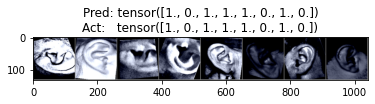

(raylet) [2022-12-30 16:55:36,255 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70862450688; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:55:46,262 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70862446592; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-30 16:55:56,269 E 138 172] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-30_12-50-58_575474_23 is over 95% full, available space: 70862446592; capacity: 4327869423616. Object creation will fail if spilling is required.


Best trial test set accuracy: 0.982
Accuracy of Real: 98.504 %
Accuracy of Spoof: 97.912 %


In [11]:
best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    best_trained_model = nn.DataParallel(best_trained_model)
print(f'Computing on {device}')

best_trained_model.to(device)
best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

test_accuracy(best_trained_model, best_trial.config["batch_size"], device)